In [7]:
import torch
import torch.nn as nn
# import torch.optibm as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from dataset_class import PatchShuffled_CIFAR10
from matplotlib import pyplot as plt
import argparse
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
batch_size = 128
learning_rate = 1e-4
l2_regularization = 0.0
transform = transforms.Compose([
        transforms.ToTensor()])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
mean = np.mean(trainset.data, axis=(0,1,2)) / 255.0  # Compute mean across all images and channels
std = np.std(trainset.data, axis=(0,1,2)) / 255.0  # Compute std across all images and channels



Files already downloaded and verified


In [8]:
data = [[1.0, 2.0], [3.0, 4.0]]
x = torch.tensor(data)
data = [[6.0,7.0], [8.0,9.0]]
y = torch.tensor(data)

print(x)
print(y)

tensor([[1., 2.],
        [3., 4.]])
tensor([[6., 7.],
        [8., 9.]])


In [9]:
a = torch.stack((x, y, ), 1)
a.shape

torch.Size([2, 2, 2])

In [10]:
a

tensor([[[1., 2.],
         [6., 7.]],

        [[3., 4.],
         [8., 9.]]])

In [11]:
torch.mean(a, dim=1)

tensor([[3.5000, 4.5000],
        [5.5000, 6.5000]])

In [12]:

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize(mean, std)  # Normalize the tensor
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000], generator=torch.Generator().manual_seed(0))

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size= batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
import torch.nn.functional as F

def img_to_patch(x, patch_size, flatten_channels=False):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape # [B, C, H, W], CIFAR10 [B, 3, 32, 32]
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size) # [B, C, H', p_H, W', p_W], CIFAR10 [B, 3, 4, 8, 4, 8]
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W], CIFAR10 [B, 4, 4, 1, 8, 8]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W], CIFAR10 [B, 16, 3, 8, 8]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W], CIFAR10 [B, 16, 192]
    return x

class PatchCNN(nn.Module):
    def __init__(self, out_1, out_2, out_3):
        super(PatchCNN, self).__init__()
        # Define the convolutional layers for each patch
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=5, padding=2)
        # self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.drop_conv = nn.Dropout(p=0.2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        self.conv3_bn = nn.BatchNorm2d(out_3)
        p=0.5
        self.fc1 = nn.Linear(out_3 * 4, 1000) 
        self.drop = nn.Dropout(p=p)
        self.fc1_bn = nn.BatchNorm1d(1000)
        
        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)
        self.fc2_bn = nn.BatchNorm1d(1000)

        # Hidden layer 3
        self.fc3 = nn.Linear(1000, 1000)
        self.fc3_bn = nn.BatchNorm1d(1000)
        
        # Hidden layer 4
        self.fc4 = nn.Linear(1000, 1000)
        self.fc4_bn = nn.BatchNorm1d(1000)
        # Final layer
        self.fc5 = nn.Linear(1000, 10)
        self.fc5_bn = nn.BatchNorm1d(10)
        

        # torch.Size([128, 3, 32, 32])
    def forward(self, x):
        # print(x.shape)
        # Apply convolution and pooling for each patch
        x = img_to_patch(x, 16)    
        # print(x.shape)
        # print('adfsd')
        patch_features = []

        for i in range(x.shape[1]):
            patch = x[:,i,:,:]
            # print(patch.shape)
            # print('a')
            patch = self.conv1(patch)
            patch = self.conv1_bn(patch)
            patch = self.maxpool1(patch)
            patch = self.drop_conv(patch)
            
            patch = self.conv2(patch)
            patch = self.conv2_bn(patch)
            patch = torch.relu(patch)
            patch = self.maxpool2(patch)
            patch = self.drop_conv(patch)
            
            patch = self.conv3(patch)
            patch = self.conv3_bn(patch)
            patch = torch.relu(patch)
            patch = self.maxpool3(patch)
            patch = self.drop_conv(patch)
            # print(f'last patch shape: {patch.shape}')
            patch = torch.flatten(patch, 1)
            # print(f'last flatten patch shape: {patch.shape}')
            patch_features.append(patch)
            # print(f'patch shape: {patch.shape}')
            # print('______________________________')
        
        patch_features = torch.stack(patch_features, dim=1)
        x = torch.mean(patch_features, dim=1)
        # print(f'x shape: {x.shape}')

        x = self.fc1(x)
        x = self.fc1_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        x = self.fc2_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc3(x)
        x = self.fc3_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc4(x)
        x = self.fc4_bn(x)
        second_last_output = x

        x = F.relu(self.drop(x))
        x = self.fc5(x)
        x = self.fc5_bn(x)
        return x, second_last_output
    

In [17]:
model = PatchCNN(64,128,512)
dummy_input = torch.randn(128, 3, 32, 32)  # Example input tensor (batch size 128)
output,s = model(dummy_input)
print("Output shape:", output.shape)

Output shape: torch.Size([128, 10])


In [18]:
import torch.optim as optim

# model  = PatchCNN()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# model.to(device)


model = PatchCNN(out_1=64, out_2=128, out_3 =512)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.2)
model.to(device)


PatchCNN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(128, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_conv): Dropout(p=0.2, inplace=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=1000, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, af

In [19]:
epochs = 100
model_class = 'Plain-Old-CIFAR10'
batch_size = 512
learning_rate = 1e-4
l2_regularization = 0.0
from tqdm import tqdm
best_acc = 0
best_model = None
# model = model_ViT
def eval_model(model, data_loader, criterion, device):
    # Evaluate the model on data from valloader
    correct = 0
    total = 0
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs,second_last_output = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    
    return val_loss / len(data_loader), 100 * correct / len(data_loader.dataset)

loss_train_list = []
loss_val_list= []
try:
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        model.train()
        for data in tqdm(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs,second_last_output = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
        # scheduler.step()
        # if epoch % 10 == 0:
        val_loss, val_acc = eval_model(model, valloader, criterion, device)
        print('epoch - %d loss: %.3f accuracy: %.3f val_loss: %.3f val_acc: %.3f' % (epoch, running_loss / len(trainloader), 100 * correct / len(trainloader.dataset), val_loss, val_acc))
        loss_train_list.append((running_loss / len(trainloader)))
        loss_val_list.append(val_loss)
        if best_acc<val_acc:
            best_model = model.state_dict()
            best_acc = val_acc
            print(f'best acc: {val_acc}')
        # else:
        #     print('epoch - %d loss: %.3f accuracy: %.3f' % (epoch, running_loss / len(trainloader), 100 * correct / len(trainloader.dataset)))


    print('Finished training')
except KeyboardInterrupt:
    pass

100%|██████████| 313/313 [00:15<00:00, 20.42it/s]


epoch - 0 loss: 1.811 accuracy: 32.650 val_loss: 1.818 val_acc: 32.960
best acc: 32.96


100%|██████████| 313/313 [00:14<00:00, 22.23it/s]


epoch - 1 loss: 1.550 accuracy: 42.795 val_loss: 1.783 val_acc: 39.230
best acc: 39.23


100%|██████████| 313/313 [00:14<00:00, 21.44it/s]


epoch - 2 loss: 1.410 accuracy: 48.255 val_loss: 1.402 val_acc: 50.210
best acc: 50.21


100%|██████████| 313/313 [00:13<00:00, 22.36it/s]


epoch - 3 loss: 1.316 accuracy: 52.297 val_loss: 1.393 val_acc: 51.420
best acc: 51.42


100%|██████████| 313/313 [00:14<00:00, 21.37it/s]


epoch - 4 loss: 1.238 accuracy: 55.263 val_loss: 1.353 val_acc: 51.850
best acc: 51.85


100%|██████████| 313/313 [00:14<00:00, 21.17it/s]


epoch - 5 loss: 1.175 accuracy: 57.858 val_loss: 1.199 val_acc: 56.880
best acc: 56.88


100%|██████████| 313/313 [00:14<00:00, 21.57it/s]


epoch - 6 loss: 1.124 accuracy: 59.960 val_loss: 1.124 val_acc: 60.310
best acc: 60.31


100%|██████████| 313/313 [00:14<00:00, 21.63it/s]


epoch - 7 loss: 1.078 accuracy: 61.405 val_loss: 1.163 val_acc: 59.280


100%|██████████| 313/313 [00:13<00:00, 22.39it/s]


epoch - 8 loss: 1.035 accuracy: 63.068 val_loss: 1.412 val_acc: 52.430


100%|██████████| 313/313 [00:14<00:00, 22.26it/s]


epoch - 9 loss: 0.995 accuracy: 64.735 val_loss: 1.264 val_acc: 57.510


100%|██████████| 313/313 [00:13<00:00, 22.51it/s]


epoch - 10 loss: 0.955 accuracy: 66.135 val_loss: 1.062 val_acc: 63.140
best acc: 63.14


100%|██████████| 313/313 [00:12<00:00, 24.43it/s]


epoch - 11 loss: 0.924 accuracy: 67.380 val_loss: 1.179 val_acc: 60.240


100%|██████████| 313/313 [00:11<00:00, 26.70it/s]


epoch - 12 loss: 0.891 accuracy: 68.495 val_loss: 1.021 val_acc: 65.070
best acc: 65.07


100%|██████████| 313/313 [00:12<00:00, 25.43it/s]


epoch - 13 loss: 0.860 accuracy: 69.828 val_loss: 1.168 val_acc: 60.400


100%|██████████| 313/313 [00:11<00:00, 26.19it/s]


epoch - 14 loss: 0.832 accuracy: 71.037 val_loss: 1.049 val_acc: 63.770


100%|██████████| 313/313 [00:11<00:00, 26.11it/s]


epoch - 15 loss: 0.806 accuracy: 71.640 val_loss: 1.001 val_acc: 65.550
best acc: 65.55


100%|██████████| 313/313 [00:12<00:00, 25.49it/s]


epoch - 16 loss: 0.785 accuracy: 72.623 val_loss: 1.078 val_acc: 64.180


100%|██████████| 313/313 [00:11<00:00, 26.63it/s]


epoch - 17 loss: 0.755 accuracy: 73.868 val_loss: 1.053 val_acc: 63.970


100%|██████████| 313/313 [00:12<00:00, 25.75it/s]


epoch - 18 loss: 0.728 accuracy: 74.595 val_loss: 1.078 val_acc: 63.660


100%|██████████| 313/313 [00:12<00:00, 25.80it/s]


epoch - 19 loss: 0.700 accuracy: 75.627 val_loss: 0.938 val_acc: 68.690
best acc: 68.69


100%|██████████| 313/313 [00:12<00:00, 25.56it/s]


epoch - 20 loss: 0.679 accuracy: 76.382 val_loss: 0.984 val_acc: 68.110


100%|██████████| 313/313 [00:11<00:00, 26.40it/s]


epoch - 21 loss: 0.653 accuracy: 77.010 val_loss: 1.095 val_acc: 65.200


100%|██████████| 313/313 [00:11<00:00, 26.22it/s]


epoch - 22 loss: 0.629 accuracy: 78.047 val_loss: 1.050 val_acc: 65.300


100%|██████████| 313/313 [00:12<00:00, 25.73it/s]


epoch - 23 loss: 0.610 accuracy: 78.662 val_loss: 1.143 val_acc: 63.690


100%|██████████| 313/313 [00:12<00:00, 25.75it/s]


epoch - 24 loss: 0.583 accuracy: 79.625 val_loss: 1.086 val_acc: 65.130


100%|██████████| 313/313 [00:12<00:00, 25.29it/s]


epoch - 25 loss: 0.566 accuracy: 80.290 val_loss: 0.949 val_acc: 69.500
best acc: 69.5


100%|██████████| 313/313 [00:12<00:00, 25.30it/s]


epoch - 26 loss: 0.546 accuracy: 81.147 val_loss: 1.074 val_acc: 66.310


100%|██████████| 313/313 [00:12<00:00, 25.15it/s]


epoch - 27 loss: 0.523 accuracy: 82.097 val_loss: 0.938 val_acc: 69.950
best acc: 69.95


100%|██████████| 313/313 [00:12<00:00, 24.90it/s]


epoch - 28 loss: 0.503 accuracy: 82.605 val_loss: 1.158 val_acc: 65.070


100%|██████████| 313/313 [00:12<00:00, 25.22it/s]


epoch - 29 loss: 0.487 accuracy: 83.085 val_loss: 1.116 val_acc: 65.340


100%|██████████| 313/313 [00:12<00:00, 25.38it/s]


epoch - 30 loss: 0.463 accuracy: 84.100 val_loss: 1.521 val_acc: 57.970


100%|██████████| 313/313 [00:12<00:00, 25.76it/s]


epoch - 31 loss: 0.443 accuracy: 84.730 val_loss: 0.988 val_acc: 70.120
best acc: 70.12


100%|██████████| 313/313 [00:12<00:00, 25.29it/s]


epoch - 32 loss: 0.428 accuracy: 85.043 val_loss: 1.085 val_acc: 67.520


100%|██████████| 313/313 [00:12<00:00, 25.78it/s]


epoch - 33 loss: 0.415 accuracy: 85.690 val_loss: 0.927 val_acc: 71.620
best acc: 71.62


100%|██████████| 313/313 [00:12<00:00, 26.08it/s]


epoch - 34 loss: 0.398 accuracy: 86.112 val_loss: 1.219 val_acc: 65.480


100%|██████████| 313/313 [00:12<00:00, 25.46it/s]


epoch - 35 loss: 0.381 accuracy: 86.752 val_loss: 0.994 val_acc: 70.320


100%|██████████| 313/313 [00:12<00:00, 25.59it/s]


epoch - 36 loss: 0.366 accuracy: 87.420 val_loss: 1.003 val_acc: 70.700


100%|██████████| 313/313 [00:12<00:00, 25.10it/s]


epoch - 37 loss: 0.353 accuracy: 87.757 val_loss: 1.106 val_acc: 68.110


100%|██████████| 313/313 [00:11<00:00, 26.28it/s]


epoch - 38 loss: 0.331 accuracy: 88.590 val_loss: 1.156 val_acc: 69.060


100%|██████████| 313/313 [00:12<00:00, 25.26it/s]


epoch - 39 loss: 0.329 accuracy: 88.743 val_loss: 1.018 val_acc: 70.250


100%|██████████| 313/313 [00:12<00:00, 25.88it/s]


epoch - 40 loss: 0.314 accuracy: 89.205 val_loss: 1.083 val_acc: 69.070


100%|██████████| 313/313 [00:12<00:00, 25.82it/s]


epoch - 41 loss: 0.300 accuracy: 89.707 val_loss: 1.065 val_acc: 70.320


100%|██████████| 313/313 [00:12<00:00, 25.76it/s]


epoch - 42 loss: 0.294 accuracy: 89.832 val_loss: 1.151 val_acc: 68.070


100%|██████████| 313/313 [00:12<00:00, 25.37it/s]


epoch - 43 loss: 0.277 accuracy: 90.450 val_loss: 1.124 val_acc: 68.590


100%|██████████| 313/313 [00:11<00:00, 26.70it/s]


epoch - 44 loss: 0.277 accuracy: 90.457 val_loss: 1.081 val_acc: 70.350


100%|██████████| 313/313 [00:12<00:00, 24.13it/s]


epoch - 45 loss: 0.258 accuracy: 91.058 val_loss: 1.068 val_acc: 70.330


100%|██████████| 313/313 [00:13<00:00, 23.14it/s]


epoch - 46 loss: 0.249 accuracy: 91.353 val_loss: 1.295 val_acc: 66.830


100%|██████████| 313/313 [00:13<00:00, 23.44it/s]


epoch - 47 loss: 0.238 accuracy: 91.885 val_loss: 1.079 val_acc: 70.810


100%|██████████| 313/313 [00:13<00:00, 23.09it/s]


epoch - 48 loss: 0.238 accuracy: 91.865 val_loss: 1.268 val_acc: 68.040


100%|██████████| 313/313 [00:13<00:00, 22.88it/s]


epoch - 49 loss: 0.225 accuracy: 92.287 val_loss: 1.418 val_acc: 65.330


100%|██████████| 313/313 [00:13<00:00, 22.56it/s]


epoch - 50 loss: 0.227 accuracy: 92.073 val_loss: 1.177 val_acc: 69.390


100%|██████████| 313/313 [00:13<00:00, 22.81it/s]


epoch - 51 loss: 0.212 accuracy: 92.812 val_loss: 1.151 val_acc: 70.330


100%|██████████| 313/313 [00:13<00:00, 22.75it/s]


epoch - 52 loss: 0.202 accuracy: 93.115 val_loss: 1.129 val_acc: 70.000


100%|██████████| 313/313 [00:13<00:00, 23.75it/s]


epoch - 53 loss: 0.201 accuracy: 93.105 val_loss: 1.114 val_acc: 71.360


100%|██████████| 313/313 [00:13<00:00, 23.02it/s]


epoch - 54 loss: 0.191 accuracy: 93.472 val_loss: 1.102 val_acc: 71.550


100%|██████████| 313/313 [00:13<00:00, 23.13it/s]


epoch - 55 loss: 0.181 accuracy: 93.823 val_loss: 1.362 val_acc: 66.760


100%|██████████| 313/313 [00:13<00:00, 23.74it/s]


epoch - 56 loss: 0.175 accuracy: 93.960 val_loss: 1.235 val_acc: 70.220


100%|██████████| 313/313 [00:13<00:00, 23.20it/s]


epoch - 57 loss: 0.172 accuracy: 94.235 val_loss: 1.130 val_acc: 71.590


100%|██████████| 313/313 [00:13<00:00, 23.09it/s]


epoch - 58 loss: 0.169 accuracy: 94.195 val_loss: 1.154 val_acc: 70.890


100%|██████████| 313/313 [00:13<00:00, 23.21it/s]


epoch - 59 loss: 0.160 accuracy: 94.558 val_loss: 1.470 val_acc: 66.490


100%|██████████| 313/313 [00:12<00:00, 25.85it/s]


epoch - 60 loss: 0.156 accuracy: 94.668 val_loss: 1.217 val_acc: 69.840


100%|██████████| 313/313 [00:12<00:00, 25.01it/s]


epoch - 61 loss: 0.152 accuracy: 94.770 val_loss: 1.361 val_acc: 68.040


100%|██████████| 313/313 [00:12<00:00, 25.82it/s]


epoch - 62 loss: 0.147 accuracy: 95.007 val_loss: 1.135 val_acc: 72.080
best acc: 72.08


100%|██████████| 313/313 [00:11<00:00, 26.10it/s]


epoch - 63 loss: 0.147 accuracy: 95.120 val_loss: 1.238 val_acc: 70.280


100%|██████████| 313/313 [00:12<00:00, 25.95it/s]


epoch - 64 loss: 0.146 accuracy: 94.983 val_loss: 1.155 val_acc: 71.040


100%|██████████| 313/313 [00:12<00:00, 26.07it/s]


epoch - 65 loss: 0.137 accuracy: 95.285 val_loss: 1.209 val_acc: 71.050


100%|██████████| 313/313 [00:12<00:00, 26.06it/s]


epoch - 66 loss: 0.133 accuracy: 95.498 val_loss: 1.125 val_acc: 71.970


100%|██████████| 313/313 [00:11<00:00, 26.11it/s]


epoch - 67 loss: 0.131 accuracy: 95.660 val_loss: 1.188 val_acc: 71.570


100%|██████████| 313/313 [00:12<00:00, 25.96it/s]


epoch - 68 loss: 0.128 accuracy: 95.647 val_loss: 1.152 val_acc: 71.680


100%|██████████| 313/313 [00:11<00:00, 26.15it/s]


epoch - 69 loss: 0.121 accuracy: 96.015 val_loss: 1.253 val_acc: 70.930


100%|██████████| 313/313 [00:11<00:00, 26.26it/s]


epoch - 70 loss: 0.124 accuracy: 95.740 val_loss: 1.193 val_acc: 71.420


100%|██████████| 313/313 [00:12<00:00, 25.50it/s]


epoch - 71 loss: 0.121 accuracy: 95.995 val_loss: 1.189 val_acc: 71.280


100%|██████████| 313/313 [00:12<00:00, 25.33it/s]


epoch - 72 loss: 0.119 accuracy: 95.935 val_loss: 1.184 val_acc: 71.950


100%|██████████| 313/313 [00:12<00:00, 24.70it/s]


epoch - 73 loss: 0.111 accuracy: 96.340 val_loss: 1.172 val_acc: 71.750


100%|██████████| 313/313 [00:12<00:00, 25.37it/s]


epoch - 74 loss: 0.111 accuracy: 96.240 val_loss: 1.170 val_acc: 72.540
best acc: 72.54


100%|██████████| 313/313 [00:12<00:00, 24.80it/s]


epoch - 75 loss: 0.104 accuracy: 96.465 val_loss: 1.166 val_acc: 72.500


100%|██████████| 313/313 [00:12<00:00, 24.56it/s]


epoch - 76 loss: 0.110 accuracy: 96.362 val_loss: 1.237 val_acc: 70.600


100%|██████████| 313/313 [00:12<00:00, 25.17it/s]


epoch - 77 loss: 0.100 accuracy: 96.737 val_loss: 1.177 val_acc: 72.630
best acc: 72.63


100%|██████████| 313/313 [00:12<00:00, 25.38it/s]


epoch - 78 loss: 0.099 accuracy: 96.685 val_loss: 1.375 val_acc: 70.340


100%|██████████| 313/313 [00:12<00:00, 25.60it/s]


epoch - 79 loss: 0.099 accuracy: 96.757 val_loss: 1.276 val_acc: 70.430


100%|██████████| 313/313 [00:12<00:00, 25.95it/s]


epoch - 80 loss: 0.103 accuracy: 96.608 val_loss: 1.271 val_acc: 70.540


100%|██████████| 313/313 [00:11<00:00, 26.10it/s]


epoch - 81 loss: 0.099 accuracy: 96.797 val_loss: 1.163 val_acc: 72.660
best acc: 72.66


100%|██████████| 313/313 [00:11<00:00, 26.26it/s]


epoch - 82 loss: 0.091 accuracy: 96.960 val_loss: 1.288 val_acc: 70.730


100%|██████████| 313/313 [00:12<00:00, 25.94it/s]


epoch - 83 loss: 0.091 accuracy: 97.017 val_loss: 1.174 val_acc: 72.740
best acc: 72.74


100%|██████████| 313/313 [00:11<00:00, 26.52it/s]


epoch - 84 loss: 0.092 accuracy: 97.032 val_loss: 1.150 val_acc: 73.010
best acc: 73.01


100%|██████████| 313/313 [00:12<00:00, 25.76it/s]


epoch - 85 loss: 0.090 accuracy: 96.957 val_loss: 1.164 val_acc: 73.050
best acc: 73.05


100%|██████████| 313/313 [00:12<00:00, 25.66it/s]


epoch - 86 loss: 0.086 accuracy: 97.168 val_loss: 1.244 val_acc: 71.520


100%|██████████| 313/313 [00:12<00:00, 25.54it/s]


epoch - 87 loss: 0.083 accuracy: 97.302 val_loss: 1.200 val_acc: 72.850


100%|██████████| 313/313 [00:12<00:00, 25.39it/s]


epoch - 88 loss: 0.082 accuracy: 97.328 val_loss: 1.165 val_acc: 73.250
best acc: 73.25


100%|██████████| 313/313 [00:12<00:00, 24.91it/s]


epoch - 89 loss: 0.085 accuracy: 97.127 val_loss: 1.263 val_acc: 71.470


100%|██████████| 313/313 [00:12<00:00, 24.66it/s]


epoch - 90 loss: 0.078 accuracy: 97.455 val_loss: 1.282 val_acc: 70.850


100%|██████████| 313/313 [00:12<00:00, 24.35it/s]


epoch - 91 loss: 0.077 accuracy: 97.550 val_loss: 1.244 val_acc: 72.480


100%|██████████| 313/313 [00:12<00:00, 24.81it/s]


epoch - 92 loss: 0.076 accuracy: 97.505 val_loss: 1.191 val_acc: 72.470


100%|██████████| 313/313 [00:12<00:00, 25.81it/s]


epoch - 93 loss: 0.074 accuracy: 97.603 val_loss: 1.273 val_acc: 71.980


100%|██████████| 313/313 [00:12<00:00, 25.25it/s]


epoch - 94 loss: 0.076 accuracy: 97.493 val_loss: 1.250 val_acc: 72.260


100%|██████████| 313/313 [00:12<00:00, 25.61it/s]


epoch - 95 loss: 0.072 accuracy: 97.623 val_loss: 1.226 val_acc: 72.480


100%|██████████| 313/313 [00:12<00:00, 25.74it/s]


epoch - 96 loss: 0.075 accuracy: 97.403 val_loss: 1.243 val_acc: 71.950


100%|██████████| 313/313 [00:12<00:00, 25.52it/s]


epoch - 97 loss: 0.074 accuracy: 97.547 val_loss: 1.240 val_acc: 72.300


100%|██████████| 313/313 [00:12<00:00, 25.90it/s]


epoch - 98 loss: 0.076 accuracy: 97.570 val_loss: 1.327 val_acc: 70.510


100%|██████████| 313/313 [00:12<00:00, 25.79it/s]


epoch - 99 loss: 0.068 accuracy: 97.720 val_loss: 1.304 val_acc: 71.370
Finished training


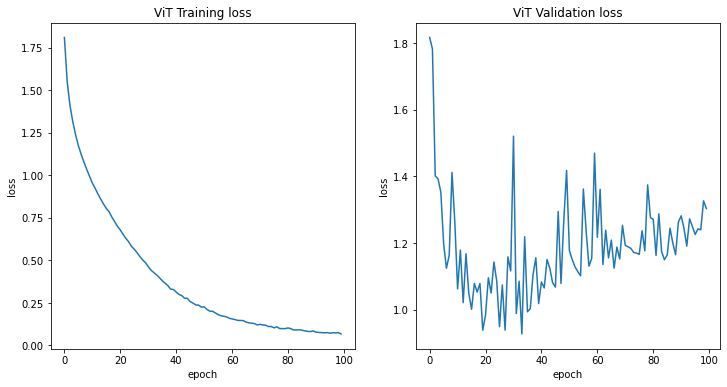

In [20]:
model.load_state_dict(best_model)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(loss_train_list)
ax1.set_title('ViT Training loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

ax2.plot(loss_val_list)
ax2.set_title('ViT Validation loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
plt.show()

In [21]:
# transform = transforms.Compose([
#         transforms.ToTensor()
#     ])
model.eval()
# Evaluate the model on the test set
test_loss, test_acc = eval_model(model, testloader, criterion, device)
print('Test loss: %.3f accuracy: %.3f' % (test_loss, test_acc))

Test loss: 1.284 accuracy: 71.580


In [22]:
from dataset_class import PatchShuffled_CIFAR10

patch_size = 16
patch_shuffle_testset = PatchShuffled_CIFAR10(data_file_path = f'test_patch_{patch_size}.npz', transforms = transform)
patch_shuffle_testloader = torch.utils.data.DataLoader(patch_shuffle_testset, batch_size=batch_size, shuffle=False)
patch_shuffle_test_loss, patch_shuffle_test_acc = eval_model(model, patch_shuffle_testloader, criterion, device)
print(f'Patch shuffle test loss for patch-size {patch_size}: {patch_shuffle_test_loss} accuracy: {patch_shuffle_test_acc}')

patch_size = 8
patch_shuffle_testset = PatchShuffled_CIFAR10(data_file_path = f'test_patch_{patch_size}.npz', transforms = transform)
patch_shuffle_testloader = torch.utils.data.DataLoader(patch_shuffle_testset, batch_size=batch_size, shuffle=False)
patch_shuffle_test_loss, patch_shuffle_test_acc = eval_model(model, patch_shuffle_testloader, criterion, device)
print(f'Patch shuffle test loss for patch-size {patch_size}: {patch_shuffle_test_loss} accuracy: {patch_shuffle_test_acc}')


Patch shuffle test loss for patch-size 16: 1.2886290490627288 accuracy: 71.58
Patch shuffle test loss for patch-size 8: 3.6222028851509096 accuracy: 34.25


In [33]:
def get_embeddings(model, images):
    model.eval()
    embeddings = []
    #model = torch.nn.Sequential(*(list(model.children())[:-1]))
    # print(len(dataloader))
    with torch.no_grad():
        # for images in dataloader:
    #         #images, labels = data
        images= torch.stack(images).to(device)
        output, pre_final_output = model(images)
        output = torch.nn.Sequential(*(list(model.children())[:-1]))

            #output = model(data)
        embeddings.append(pre_final_output.cpu().numpy())  # Assuming output is a numpy array
    return np.concatenate(embeddings, axis=0)

In [34]:
unique_indices = np.random.choice(len(testset), 25, replace=False)
    #print(unique_indices)
original_examples = [testset[i][0] for i in unique_indices]
original_labels = [testset[i][1] for i in unique_indices]  
patch16=patch_shuffle_testset
patch8=patch_shuffle_testset

original_examples_16 = [patch16[i][0] for i in unique_indices]
original_examples_8 = [patch8[i][0] for i in unique_indices]
original_labels=original_labels*3
original_examples.extend(original_examples_16)
original_examples.extend(original_examples_8)


In [35]:
train_features=get_embeddings(model, original_examples)

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(train_features)
a = (reduced_data,original_labels)

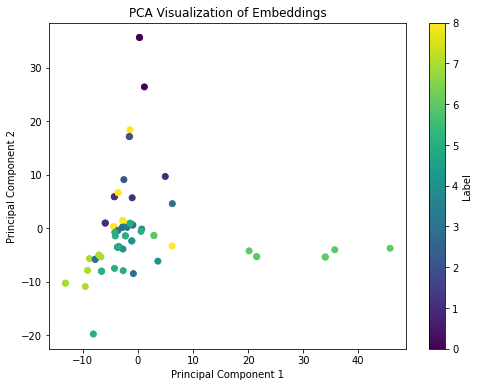

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=original_labels, cmap='viridis')
plt.colorbar(label='Label')
plt.title('PCA Visualization of Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()